# Manifold Learning and Dimensionality Reduction: Linear approaches

In many biomedical applications we will be faced with datasets that are represented with high dimensional featuresets but relatively few examples. This increases the chances of overfitting as, in ever higher dimensions, the same amount of data fills the featurespace more and more sparsely. Specifically, if we divide a region of space into regular cells we can see that the number of such cells grows exponentially with the dimensionality of the space:

<img src="imgs/curseofdimensionality.png" style="max-width:100%; width: 50%; max-width: none">

The problem with an exponentially large number of cells is that we would need an exponentially large quantity of training data in order to ensure that the cells are not empty. Without this the chance of finding a separating hyperplane by chance becomes easier, and we become prone to overfitting.  What we need therefore is some way of reducing the featurespace such that the number of features does not significanlty exceed that of the number of data examples. This can be done in a number of ways: feature selection (which you will learn about in future lectures) and manifold learning, which we describe here. 

Manifold Learning describes a family of methods that seek to map the data into a lower dimensional space by exploiting the underlying geometry of the data.  Typically this is made possible because real world data are subject to physical laws and thus have limited degrees of freedom. This tends to mean that data generated by real world processes live on a low dimensional manifold, embedded within the high dimensional feature space. To explain what this means we can use a fairly artificial example: the 'Swiss roll model:' 

<img src="imgs/swissrollmodel.png" style="max-width:100%; width: 75%; max-width: none">

Here it is clear that whilst the data lives in three dimensions, the geometry of the data is better represented in two (the result of unrolling the embedded representation). This underlying geometry can be determined by exploiting the local neighbourhood structure of the data. In this way it can be shown that the euclidean distance between two different points on the roll in three dimensions can vastly mispresent the true distance along the underlying manifold.

Thus, manifold learning techniques are designed to map the data to a new space that better represents the underlying geometry of the data, in this way enabling the use of simpler learning methods that can more sensitivitely cluster or classify the underlying data. Many different methods for manifold learning exist and these can be split into linear methods (that seek to find a sub-space of the data through linearly transforming the data) and non-linear approaches that more successully utlise the local neighbourhood structure of the data. In this lecture we will discuss linear approaches: specifically PCA and ICA. Next week will will introduce Laplacian Eigenmaps and Spectral clustering, which will allow learning of much more complex non-linear structures.

Importing generic modules used throughout the notebook:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, Image
from sklearn.decomposition import PCA

%matplotlib inline 

## Linear Transforms

We start by discussing linear transforms as these form a core component of all methods in this lecture.

A linear transformation, $ T:\mathbb{R}^n \rightarrow \mathbb{R}^m$ , is a function which satisfies

1. $T(\mathbf{x_1} +\mathbf{x_2})=T(\mathbf{x_1})+ T(\mathbf{x_2}) \; \forall \mathbf{x_1}, \mathbf{x_2} \in \mathbb{R}^n $  (additivity)
2. $T(\alpha \mathbf{x_1})=\alpha T(\mathbf{x_1}) \; \forall \mathbf{x_1} \in \mathbb{R}^n ; \alpha \in  \mathbb{R} $ (scalar multiplicativy)
3. Preserves origin 	


The action of a matrix on a vector space is a linear transform 

i.e. consider the action of the matrix A=$\begin{pmatrix} 
3 & 0 \\ 0 & 1 \\ \end{pmatrix} $ on the vector $\begin{pmatrix} x \\ y \\ \end{pmatrix} $ 

$ \begin{pmatrix} x' \\  y'\\ \end{pmatrix}=\begin{pmatrix} 3 & 0 \\ 0 & 1 \\ \end{pmatrix} \begin{pmatrix} x \\ y\\ \end{pmatrix} = x \begin{pmatrix} 3 \\ 0\\ \end{pmatrix} + y \begin{pmatrix} 0 \\ 1\\ \end{pmatrix}$ 

Applied to a cluster of grid points we can clearly see this transform as a stretch in the x-axis:

<img src="imgs/gridtransform.png" style="max-width:100%; width: 75%; max-width: none">

This may be more clearly shown through the following matplotlib animation developed using code adapted from https://dododas.github.io/linear-algebra-with-python/posts/16-12-29-2d-transformations.html
and https://notgnoshi.github.io/linear-transformations/

Note: you need ffmpeg installed for this to run. In Anaconda Prompt run

```conda install -c menpo ffmpeg```


In [4]:
import animate_transforms as an
from matplotlib import  rc

rc('animation', html='html5')


A = np.column_stack([[3, 0], [0, 1]])
anim = an.animate_transform(A, repeat=True)
anim

**Optional Exercise:** Try changing A to different matrix forms and experiment with the different linear transforms you can achieve. What types of transforms are these describing?

e.g. Try A=$\begin{pmatrix} 2 & 0.5 \\ 0.5 & 1 \\ \end{pmatrix} $,  A=$\begin{pmatrix} 1 & 2 \\ 0 & 1 \\ \end{pmatrix} $ and a rotation of the form  A=$\begin{pmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta \\ \end{pmatrix} $

### Eigendecomposition

Eigendecomposition presents linear operators in a simplied, diagonalised form. Specifically, eigenvectors of linear transforms are (non-zero) vectors which remain unchanged (with exception of a scale factor) following application of the transform e.g (taken from [wikipedia](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors)).

<img src="imgs/mona_lisa_example.png" style="max-width:100%; width: 50%; max-width: none">

Here, the blue vector represents an eigenvector as its direction remains unchanged by the application of a shear transform. On the other hand the red vector cannot be an eigenvector, since its direction is changed. Eigenvalues represent the scaling factor with with the magnitude of the eigenvector changes under the transformation.

Thus eigenvectors $\mathbf{v}$ of a matrix $\mathbf{A}$ obey the following equation:

$$A\mathbf{v}=\lambda \mathbf{v}$$

and thus may be found by starting from the characteristic equation:

$$A\mathbf{v}-\lambda \mathbf{v}=0$$
$$ \rightarrow (A-\lambda \mathbf{I})\mathbf{v}=0$$
$$ \rightarrow |A-\lambda \mathbf{I}|=0$$

Since we have already defined $\mathbf{v}$ to be non zero. Here $\mathbf{I}$ is the identity matrix. Note, the determinant ($ \det \mathbf{B}$ or $|B|$) of a 2D matrix:

$$ \begin{pmatrix} 
a & b \\ 
d & c \\ 
\end{pmatrix} $$

is defined as:

$$ |B|= ac-bd $$

Thus, for linear transform:

$$ A= \begin{pmatrix} 
3 & 0 \\ 
0 & 1 \\ 
\end{pmatrix} $$

We estimate $|A-\lambda \mathbf{I}|= 0 $ as:

$$ \rightarrow \begin{pmatrix} 
3-\lambda & 0 \\ 
0 & 1-\lambda \\ 
\end{pmatrix}=0 $$

$$ \rightarrow (3-\lambda)(1-\lambda)=0 $$.

Thus, $(3-\lambda)$ and $(1-\lambda)$ must equal zero, and the eigenvalues of this linear transform are 3 and 1. Accordingly estimating the eigenvector for $\lambda=3$ results from:

<img src="imgs/eigenvectors_forlambda_3.png" style="max-width:100%; width: 30%; max-width: none">

Representing a stretch in the x axis. And for $\lambda=1$:

<img src="imgs/eigenvectors_forlambda_1.png" style="max-width:100%; width: 30%; max-width: none">

Representing the unmodified y axis

### A note on Affine Transforms (optional)

Some of you, especially those that have been introduced to the concepts of image registration, may have heard of Affine Transformations. These are linear functions, but do not strictly meet the necessary mathematical conditions of a linear transform as they break the conditions of additivity; for example
$f(\mathbf{x})=b\mathbf{x} +c $; is an affine transformation; lets test

$$T(\mathbf{x_1} +\mathbf{x_2})=T(\mathbf{x_1})+ T(\mathbf{x_2}) \; \forall \mathbf{x_1}, \mathbf{x_2} \in \mathbb{R}^n $$  

$RHS=b \mathbf{x_1} + c + b \mathbf{x_2} +c =b(\mathbf{x_1} +\mathbf{x_2}) +2c$ 

$LHS=b(\mathbf{x_1} +\mathbf{x_2}) +c$ 

$LHS \neq RHS$
	            			            
Strictly an affine transformation combines a linear transformation with translation



## Exercise 1: Estimating eigenvectors and values from a linear transformation matrix

Estimate (on paper) the eigenvectors and values of:

$$ A= \begin{pmatrix} 
2 & 1 \\ 
1 & 2 \\ 
\end{pmatrix} $$

Thre solution is given in the lecture slides.

# Principal Component Analysis (PCA)

Using eigendecomposition of linear transforms we can learn a new basis, which we can use to straightforwardly transform our data. In the case of PCA, the specific goal is to estimate a new basis which optimally reflects the variance of the data. Specifically, we wish to project our data onto this basis to obtain a new rotated frame of reference, in which our data covariance is diagonalised.

By way of example, let's return to a dataset you first saw previously in week 2: neonatal gestational age versus brain volume. 

<img src="imgs/ga_versus_brain_volume.png" style="max-width:100%; width: 50%; max-width: none">

This shows strong correlation between the two features such that it would not be unreasonable to assume that (allowing for sources of noise) we might approximate one from the other. In other words, all meaningful relationships might be best represented in terms of a single projection $\mathbf{u_1}$:

<img src="imgs/ga_versus_brain_volume_with_comp.png" style="max-width:100%; width: 50%; max-width: none">

Our goal with PCA is to estimate this new basis $\mathbf{u}$, in such as way that the orthogonal projection of data points  onto this sub-space maximises the variance of the projected points. For example, using a simplified dataset with four points, where the original points are represented in orange, the new basis is represented by a red line and the points projected onto this line are in green:

<img src="imgs/simplePCA.png" style="max-width:100%; width: 40%; max-width: none">

Remember that the projection of one vector ($\mathbf{x}$) onto another ($\mathbf{u_1}$) is estimated as 

<img src="imgs/vectorprojection.png" style="max-width:100%; width: 40%; max-width: none">

This can be estimated from the dot product:

$$ \mathbf{x.u_1} = |\mathbf{x}||\mathbf{u_1}|cos \theta $$

Therefore the projection $|\mathbf{x}|cos \theta = \frac{\mathbf{x.u_1}}{ |\mathbf{u_1}|}$ or $\mathbf{x.u_1}$ if $\mathbf{u_1}$ is a unit vector.

Assuming $\mathbf{u_1}$ **is** a unit vector, once projected the variance of the projected data is given by:

$$\frac{1}{n-1} \sum_{n=1}^N  (\mathbf{u_1^Tx_n}-\mathbf{u_1^T\bar{x}})^2 = \mathbf{u_1^TSu_1} $$

where, $ S= \frac{1}{n-1} \sum_{n=1}^N  (\mathbf{x_n}-\mathbf{\bar{x}})^T (\mathbf{x_n}-\mathbf{\bar{x}}) $ and $\mathbf{\bar{x}}$ represents the mean of the data.

We seek $\mathbf{u_1}$ such that when we project our data onto it, we will maximise the representation of the variance. Thus the derivation of PCA can be found by maximising the projected variance $\mathbf{u_1^TSu_1}$  w.r.t. $\mathbf{u_1}$, whilst constraining any solution to prevent $\mathbf{u_1} \rightarrow \infty$ and instead return a unit vector: $\mathbf{u_1}^T\mathbf{u_1}=1 $. This can be enforced through use of a Lagrange multiplier $\lambda_1$:

$$ \mathbf{u_1^TSu_1} + \lambda_1(1-\mathbf{u_1}^T\mathbf{u_1}) $$

which is maximised by the taking the derivative w.r.t. $\mathbf{u_1}$ to return:

$$  \mathbf{Su_1} - \lambda_1\mathbf{u_1}=0 $$
$$ \rightarrow  \mathbf{Su_1}=\lambda_1\mathbf{u_1} $$

And, this derived relationship may be taken to higher dimensions by making the assumption that the basis vectors $\mathbf{u_i}$ must be orthogonal and thus uncorrelated with one another:

$$ cov(\mathbf{u_1},\mathbf{u_2})=\mathbf{u_2^TSu_1}= \mathbf{u_2}\lambda_1 \mathbf{u_1} $$

Taking in this additional constraint leads to the following revised Langrangian, maximised by taking the derivative w.r.t $\mathbf{u_2}$

$$ \mathbf{u_2^TSu_2} + \lambda_2(1-\mathbf{u_2}^T\mathbf{u_2}) - \phi\mathbf{u_2}^T\mathbf{u_1} $$

$$  \mathbf{Su_2}-\lambda_2\mathbf{u_2} - \phi\mathbf{u_1} = 0 $$

Left multiplying through by $\mathbf{u_1}$ gives:
$$  \mathbf{u_1^TSu_2}-\lambda_2\mathbf{u_1^Tu_2} - \phi\mathbf{u_1^Tu_1} = 0 $$

where, from above we note that due to orthogonality $\mathbf{u_1^TSu_2}$ and $\lambda_2\mathbf{u_1^Tu_2}$ must equal zero. Thus by definition $\phi\mathbf{u_1^Tu_1}$ must equal zero, see:

$$  \mathbf{u_1^TSu_2}-\lambda_2\mathbf{u_1^Tu_2} - \phi\mathbf{u_1^Tu_1} = 0 $$
$$ \rightarrow 0 - 0 - \phi\mathbf{u_1^Tu_1} = 0$$

Accordingly, as this additional constraint can be shown to be zero, this simply means that $  \mathbf{Su_2}=\lambda_2\mathbf{u_2} $ and the second basis vector $\mathbf{u_2}$ is the second eigenvector of the covariance matrix. 

### A note on Langrangian multipliers (optional)

The above derivation takes a Langrangian approach to constrained optimisation.  This supports estimation the local maxima and minima of a function subject to equality constraints without need for explicit parameterisation of the constraints. 

Specifically for function $f(x)$ and constraints $g(x)$ given problem:
maximise $f(x)$
s.t. $g(x)=0$ 

And instead solve for:
$L(x,\lambda)=f(x) -\lambda g(x)$

In the above example the function is $ \mathbf{u_1Su_1^T} $ and the constraint is $\mathbf{u_1}^T\mathbf{u_1}=1 $. Langrangian optimisation also appears in support vector machine optimisation

## Estimating PCA eigenvectors from the Covariance matrix

Thus, all principal eigenvectors may be obtained from eigen-decomposition of the mean-centred data covariance matrix $\mathbf{S}=\frac{1}{n-1} \mathbf{(X- \mathbf{\bar X})(X-\mathbf{\bar X})^T}$, where $\mathbf{X} \in \mathbb{R}^{m\times n}$, n= number of samples/examples and m =numbers of features, and mean $\mathbf{\bar X} =\frac{1}{n} \sum_i^n \mathbf{ X_i} $; 

This results in the following eigenvalue equation (in matrix representation):

$\mathbf{SU}=\mathbf{\Lambda U}$,


with $\mathbf{U} \in \mathbb{R}^{m \times m}$ and $\mathbf{\Lambda} \in \mathbb{R}^{m \times m}$; $\mathbf{\Lambda}$ is a diagonal matrix e.g. 

$\mathbf{\Lambda}= \begin{pmatrix} 
\lambda_1 & 0 & 0 & \dots & 0 \\
0 & \lambda_2 & 0 & \dots & 0 \\ 
\vdots & \vdots  &  \vdots  & \vdots  & \vdots  \\ 
0 & 0 & 0 & \dots & \lambda_m \\ 
\end{pmatrix}$

With the PCA basis estimated as eigenvectors $\mathbf{U}$, all data $\mathbf{X}$ may be projected into this new basis as $\mathbf{Y} = \mathbf{U^TX}$


## Exercise 2: Estimating PCA bases from data covariance matrices

Given the data matrix found in the file random_data.txt, estimate the PCA eigenspace from the eigenvectors of the data covariance matrix, and use this to project all data into the new basis. 

In the next window complete the function for estimation of pca from the sample covariance matrix ($\mathbf{S}=\frac{1}{n-1} \mathbf{X X^T}$). Replace ```None``` values with correct code so as to :

1.  mean centre the data ($\mathbf{X}=\mathbf{X}-\mathbf{\bar X}$)
2.  estimate the data covariance matrix 
3.  Evaluate the eigenvectors and values of the covariance matrix.

Hints: 
 - you may use numpy's mean function (```np.mean(..)```), but check that the dimensionality of your mean vector matches what you expect. Your goal is to estimate the mean and variance of the features.
 - Please implement the sample covariance; you can check its accuracy against the output of ```np.cov()``` 
 - For eigenvalue and eigenvectors use numpys linalg.eig(..) function (see Numpy.ipynb and https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html for more details)

In [11]:
# create function to estimate PCA from covariance matrix
def pca_from_covariance(X):
    
    """
    Function to estimate PCA from sample covariance matrix:
    
    Input args:
        X : data matrix with shape (n_features, n_samples)
        
    Output args:
        u : eigenvectors of the sample covariance matrix
        d : eigenvalues of the sample covariance matrix
        X : centered data
    """
    
    # 2.1.1 estimate mean vector
    # so here we are interested in covariance across samples, this means that your covariance matrix will be shape (feature,features) 
    # with variance, for each feature, across all samples on the diagonal and covariance (between feature dimensions) on the off-diagonal
    # this mean that we also need one mean for each vector 
    # as our data matrix is shape (features,sample) this can be achieved by estimating means for each row
    # this means you must estimate means over columns (axis=1) - np.mean(X,axis=1)
    X_mean=np.mean(X,axis=1)
    

    # 2.1.2 mean center
    # to subtract this mean vector from your data matrix numpy will complain unless you reshape to a 2D array shape (features,1)
    # you can add a dimension using reshape .reshape(X.shape[0],1)
    X=X-X_mean.reshape(X.shape[0],1) 

    # 2.2 estimate data covariance matrix
    # you are looking for (co)variance across samples this means you will get a variance estimation for each feature
    # and a symmetric off-diagonal covariance between the pair of features returning covariance shape (features,features)
    # The choice of XX.T  or X.TX (where X.T is X.transpose()) reflects this 
    # which combination gives the correct shaped covariance?
    # you must then normalise by (1/(n_samples- 1))
    S=(1/(X.shape[1]-1))*np.matmul(X,X.transpose())

    # 2.3 estimate eigenvalues and vectors using inbuilt numpy functions
    d,u=np.linalg.eig(S)
    
    # 2.3 sort eigenvalues and vectors by size using inbuilt numpy functions
    # here [::-1] ensures it returns the array in reverse order https://stackoverflow.com/questions/15748001/reversed-array-in-numpy
    idx = d.argsort()[::-1]   
    
    # idx gives the permutation - which eigenvalues at which locations correpond to the 1,2,3... etc biggest values
    # now you need to apply those to the eigenvalue and eigenmatrix array to permute both into descending order (by eigenvalue)
    # don't forget each eigenvalue is paired to an eigenvector so you must change both!
    d = d[idx] 
    u = u[:,idx]
    
    return u,d,X

4. Now apply your function to the data loaded from random_data.txt, project all data onto the PCA eigenspace

We also plot the results of the transformation:

(2, 200)
Eigenvalues are: [0.7625315 0.0184779]
Eigenvectors are: 
 [[ 0.94446029 -0.32862557]
 [ 0.32862557  0.94446029]]
Projected coordinates for first two data points are: 
 [[-0.67676923  1.07121393 -0.72791236]
 [ 0.0597386   0.25724006 -0.16866994]]


Text(0, 0.5, '$PC 2$')

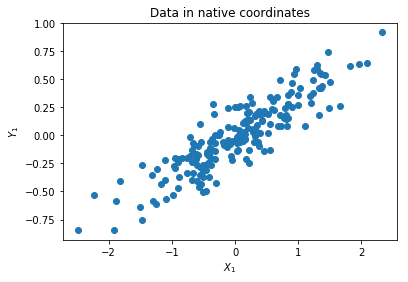

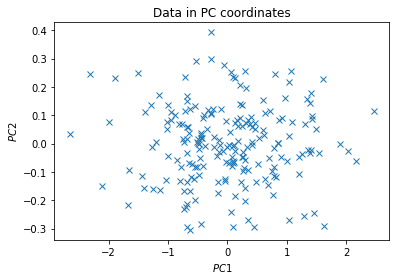

In [12]:
# load data
X=np.loadtxt('random_data.txt')
print(X.shape)

# perform pca using pca_from_covariance(X)
vecs,vals,X_centered=pca_from_covariance(X)
print('Eigenvalues are:', vals)
print("Eigenvectors are: \n {}".format(vecs))

# 2.4 project data 
# Y=U.T X  (from lecture) 
#therefore need matrix multiplication of the transpose of the eigenvectors and the centered data matrix
Y= np.matmul(vecs.transpose(),X_centered)
print("Projected coordinates for first two data points are: \n {}".format( Y[:,:3]))

# plot original data
plt.figure()
plt.plot(X[0],X[1],'o')
plt.title('Data in native coordinates')
plt.xlabel('$X_1$')
plt.ylabel('$Y_1$')

# plot transformed data
plt.figure()
plt.plot(Y[0],Y[1],'x')
plt.title('Data in PC coordinates')
plt.xlabel('$PC 1$')
plt.ylabel('$PC 2$')


We can now visualise the principal components in relation to our original data. For this we can plot them as vectors, using the eigenvalue to define the  magnitude of the vector:

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


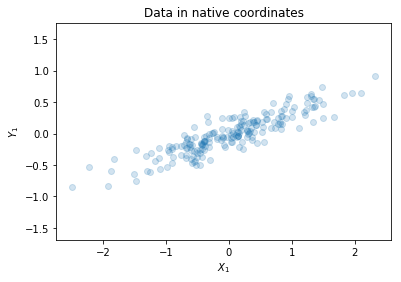

In [8]:
# plot original data
plt.figure()
plt.scatter(X[0],X[1], alpha=0.2)
plt.title('Data in native coordinates')
plt.xlabel('$X_1$')
plt.ylabel('$Y_1$')

for length, vector in zip(vals, vecs.transpose()):
    v = vector * 3 * np.sqrt(length)
    draw_vector(np.mean(X,axis=1),np.mean(X,axis=1) + v)
plt.axis('equal');


## Singular Value Decomposition (SVD)

Alternatively PCA eigenvectors and values may be estimated through Singular Value Decomposition (SVD). This decomposition allows spectral (eigen) decomposition of any matrix (including non-square matrices). 

For any $(m \times n)$ matrix $\mathbf{X}$, where $n \geq m $ SVD is defined as:

$$ \mathbf{X}=\mathbf{U\Lambda V^T}$$

Where, $\mathbf{U} \in \mathbb{R}^{m\times m }$, with orthonormal columns ($\mathbf{U}^T\mathbf{U} = \mathbf{I}$), represents the left singular vectors of matrix $\mathbf{X}$; $\mathbf{V} \in \mathbb{R}^{n\times n }$, ($\mathbf{V}^T\mathbf{V} = \mathbf{I})$ represents the right singular vectors of matrix $\mathbf{X}$; and $\mathbf{\Lambda} \in \mathbb{R}^{m\times n }$ is a diagonal matrix with positive or zero elements, called the singular values. 

The relationship to PCA may be seen as follows: first construct two square matrices  $\mathbf{XX^T}$ and $\mathbf{X^TX}$:

$$\rightarrow  \mathbf{XX^T}=\mathbf{U\Lambda V^TV\Lambda^T U^T= U \Lambda \Lambda^T U^T}$$
$$\rightarrow  \mathbf{X^TX}= \mathbf{V \Lambda^T \Lambda  V^T}$$

For the case that $n \geq m $ we can show that $\mathbf{XX^T}$ and $\mathbf{X^TX}$ share $m$ eigenvalues, and the remaining $n-m$ are zero. This can be seen from the eigendecomposition of $\mathbf{XX^T= U \Lambda \Lambda^T U^T}$, which (as a square matrix of size $m \times m $) has $m$ eigenvalues and eigenvectors. These correspond to the columns of $\mathbf{U}$ and the squared diagonal elements of $\mathbf{\Sigma}$, as shown by multiplying both sides by $\mathbf{U}$ :

$$  \mathbf{XX^T= U \Lambda \Lambda^T U^T}$$
$$\rightarrow  \mathbf{XX^TU}= \mathbf{U \Lambda \Lambda^T }$$

Thus for a single eigenvector $\mathbf{u}$  and corresponding singular value $\sigma^2$ :

$$  \mathbf{XX^Tu}= \mathbf{\sigma^2 u}$$

Multiply both sides with $\mathbf{X^T}$:

$$  \mathbf{X^TXX^Tu}= \mathbf{\sigma^2 X^Tu}$$
$$ \rightarrow \mathbf{(X^TX)X^Tu}= \mathbf{\sigma^2 X^Tu}$$


Demonstrates that $\mathbf{v=X^Tu}$ is an eigenvector of $\mathbf{X^TX}$, also with eigenvalue $\sigma^2$. Thus $\mathbf{XX^T}$ and $\mathbf{X^TX}$ share $m$ eigenvalues. All remaining $n-m$ eignvalues are zero, as shown by the fact that the matrix of singular values has rectangular form:

<img src="imgs/sigma.png" style="max-width:100%; width: 40%; max-width: none">
<br>

Note, the singular values are related to the eigenvalues of the covariance matrix ($\lambda$, defined above) as:

$$\lambda_i=\frac{\sigma_i^2}{n-1}$$



### Why use SVD instead of the covariance method?

For rank deficient matrices (where $𝑛 \gg 𝑚 $, or vice versa) SVD is much more numerically stable, since many $\lambda_𝑖$ will be very near 0; the covariance matrix will be rank-deficient and ill-conditioned; therefore eigen-decomposition will become numerically unstable


## Exercise 3

Given the data matrix found in the file random_data.txt, estimate the PCA eigenspace through Singular Value Decomposition (SVD).  Project all data into the new basis (as before).

1. First complete the function ```pca_from_svd``` replacing ```None``` with the correct code. 
2. In the following window apply the function to the matrix $\mathbf{X}$ as before (done for you). 
3. Estimate the explained variance (equivalent to the eigenvalues of the covariance matrix) by transforming the singular values
4. Project the data into the new basis and plot the result
5. Finally compare against sklearn pca method

Hints:
- Use https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html


In [27]:
# create function to estimate PCA from SVD
def pca_from_svd(X):
    
    """
    Function to estimate PCA through SVD
    
    Input args:
        X : data matrix with shape (n_features, n_samples)
        
    Output args:
        u : left singular vectors 
        d : singular values
        v : right singular vectors
        X : centered data
    """
    # 3.1.1  mean center 
    # as before
    X_mean=X-np.mean(X,axis=1).reshape(X.shape[0],1)

    # 3.1.2 estimate eigenvalues and vectors of X using SVD
    u,d,v=np.linalg.svd(X)
   
     
    return u,d,v,X

SVD singular values are: [12.32588965  1.92905448]
Explained Variance  :  [0.76345505 0.01869975]
left singular vectors are: 
 [[-0.94465994 -0.3280512 ]
 [-0.3280512   0.94465994]]
Projected coordinates for first two data points are: 
 [[ 0.64648698 -1.10137577  0.69749121]
 [ 0.04447862  0.24304296 -0.18396097]]


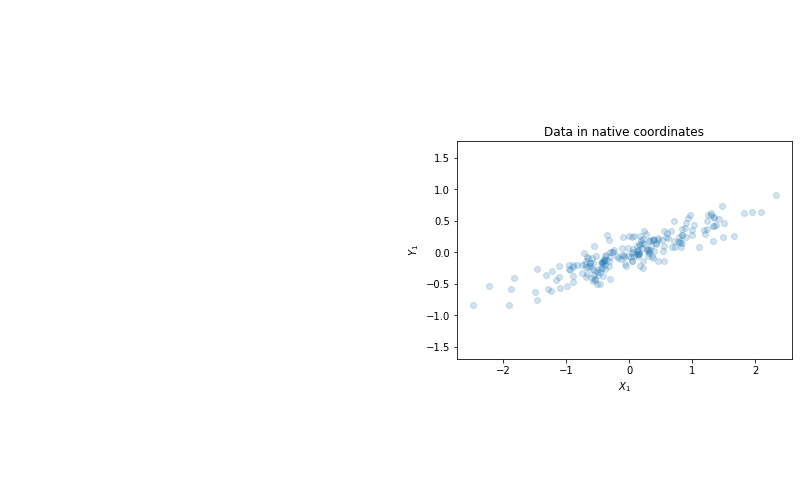

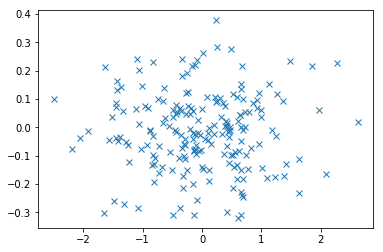

In [32]:
# 3.2 perform pca using pca_from_svd(X)
leftvecs,vals,rightvecs,X_centered=pca_from_svd(X)

# 3.3. convert singular values to explained variance
# lambda=sigma^2/(n-1) i.e. the singular values squared divided by (number of samples -1)
# You can get the number of samples from the shape of your data matrix - provided you pick the right dimension
# check that the lambdas you get are approx the same as for the covariance implementation (ex.2) 
# if not double check you are normalising by n (X.shape[1]) and not m (X.shape[0]) 
# double check demoninator has brackets etc
lambdas=(vals**2)/(X.shape[1]-1)

print('SVD singular values are:', vals)
print('Explained Variance  :  {}'.format(lambdas))
print("left singular vectors are: \n {}".format(leftvecs))

# 3.4 transform data
# you choice to project onto the singular vectors with the length corresponding to the feature dimension
# in this case the left singular vectors correspond to covariance matrix XX.T and the right XX.T 
# thus in this case you want the left but it will always depend on how you pass your data to the SVD function and which dimenion you ar einterested in
Y=np.matmul(leftvecs.transpose(),X_centered)
print("Projected coordinates for first two data points are: \n {}".format( Y[:,:3]))

# plot original data with SVD eigenvectors (why will the vectors not show up!!)
plt.scatter(X[0],X[1], alpha=0.2)
plt.title('Data in native coordinates')
plt.xlabel('$X_1$')
plt.ylabel('$Y_1$')

for length, vector in zip(vals, leftvecs.transpose()):
    v = vector * 3 * np.sqrt(length)
    draw_vector(np.mean(X,axis=1),np.mean(X,axis=1) + v)
plt.axis('equal');


plt.figure()
plt.plot(Y[0],Y[1],'x')



Now compare to the Scikit-Learn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [21]:
from sklearn.decomposition import PCA

#3.5.1 instantiate and fit model (two lines)
model=PCA(n_components=2) #n_components is an optional argument PCA() will return same result here as max dim is 2 for features
# sklearnexpects data matrix with shape (n_samples,n_features) do you need transpose
# remember fit will onlt fit the PCA if you want to project data as well use fit_transform()
model.fit(X.transpose()) 

# get attributes: 1) explained variance (lambdas); 2) singular values (gammas); 3) components
explained_variance=model.explained_variance_
singular_values=model.singular_values_
components=model.components_

print('Explained variance (lambdas): {}'.format(explained_variance))
print('Singular values (gammas):  {}'.format(singular_values))
print('Principal components: \n {}'.format(components))



Explained variance (lambdas): [0.7625315 0.0184779]
Singular values (gammas):  [12.31843207  1.91757691]
Principal components: 
 [[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


## PCA for dimensionality reduction

Returning to the case made at the beginning of the lecture, in many cases we may wish to reduce the dimensionality of our featurespace. This may be down to the curse of dimensionality, such that the problem has many more features than examples, but equally you may find, that even for a relatively small number of features, many are linearly correlated, redundant for the problem at hand, or may simply reflect noise in the data.

In these cases PCA may be used for dimensionality reduction. This occurs naturally through SVD since, for $ n \gt m$, $n-m$ singular values will be zero. Nevertheless, further reductions can be achieved by selecting the eigenvectors corresponding to the $k$ largest eigenvalues ($k \lt m$).

The choice of $k$ eigenvectors may be made by examining the cumulative distribution of eigenvalues, and selecting a cut-off at the point where growth levels off.

<img src="imgs/cdf_eigenvalues_cutoff.png" style="max-width:100%; width: 40%; max-width: none">


## Exercise 4: Dimensionality Reduction

Apply PCA based dimensionality reduction to the problem of prediction of neonatal gestation age from regional volumes. This builds from examples used in regression lectures.

1.  Run through notebook: 5.2.PCA_GA_estimation.ipynb
